In [8]:
correction_list = {
    "Kim K": "Kim K.",
    "Al Ghareeb M.": "Al-Ghareeb M.",
    "Al Khulaifi N.G.": "Al-Khulaifi N.G.",
    "Alawadhi O.": "Al-Awadhi O.",
    "Bahrouzyan O.": "Al-Awadhi O.",
    "Haji A.": "Al-Haji A.",
    "Hajji A.": "Al-Haji A.",
    "El Aarej M.": "El-Aarej M.",
    "El Amrani R.": "El-Amrani R.",
    "El Aynaoui Y.": "El-Aynaoui Y.",
    "Granollers Pujol G.": "Granollers-Pujol G.",
    "Granollers G.": "Granollers-Pujol G.",
    "Granollers M.": "Granollers-Pujol M.",
    "Al Mutawa J.": "Ali Mutawa J.M.",
    "Al-Mutawa J.": "Ali Mutawa J.M.",
    "Bogomolov Jr. A.": "Bogomolov Jr.A.",
    "Bogomolov A.": "Bogomolov Jr.A.",
    "Carreno Busta": "Carreno-Busta",
    "Chela J.": "Chela J.I.",
    "Dutra Silva R.": "Dutra da Silva R.",
    "Dutra Da Silva R.": "Dutra da Silva R.",
    "Ferrero J.": "Ferrero J.C.",
    "Gambill J. M.": "Gambill J.M.",
    "Guzman J.": "Guzman J.P.",
    "Haider-Mauer A.": "Haider-Maurer A.",
    "Zayid M. S.": "Zayid M.S.",
    "De Bakker T.": "de Bakker T.",
    "De Chaunac S.": "de Chaunac S.",
    "De Greef A.": "de Greef A.",
    "De Heart R.": "de Heart R.",
    "De Loore J.": "de Loore J.",
    "De Minaur A.": "de Minaur A.",
    "De Schepper K.": "de Schepper K.",
    "De Voest R.": "de Voest R.",
    "Del Bonis F.": "del Bonis F.",
    "Del Potro J.": "del Potro J.M.",
    "Del Potro J. M.": "del Potro J.M.",
    "Del Potro J.M.": "del Potro J.M.",
    "Van D. Merwe I.": "van D. Merwe I.",
    "Van Der Merwe I.": "van Der Merwe I.",
    "Van Lottum J.": "van Lottum J.",
    "Van Rijthoven T.": "van Rijthoven T.",
    "Van der Dium A.": "van der Dium A.",
    "Van der Merwe I.": "van der Merwe I.",
    "Munoz De La Nava D.": "Munoz de la Nava D.",
    "Munoz de La Nava D.": "Munoz de la Nava D.",
    "Munoz-De La Nava D.": "Munoz de la Nava D.",
    "Di Mauro A.": "di Mauro A.",
    "Di Pasquale A.": "di Pasquale A.",
}

drop_list = ["W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5", "CBW", "CBL", "GBW", "GBL", "IWW", "IWL", "SBW", "SBL", "B&WW", "B&WL", "EXW", "EXL", "UBW", "UBL", "LBW", "LBL", "SJW", "SJL", "MaxW", "MaxL", "AvgW", "AvgL", "WPts", "LPts"]

Let's download, save, cleanup, and agregate the data into a dataframe and and save it to a csv file. We also caculate the elo rate of each player right before the game as well as the probability for the winner to win the game based on the elo rates of the two players.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

url_base = "http://tennis-data.co.uk/"

sess = requests.session()
df_list = []
for year in range(2000, 2013):
    url = f"{url_base}/{year}/{year}.xls"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xls", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))

for year in range(2013, 2025):
    url = f"{url_base}/{year}/{year}.xlsx"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xlsx", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))
sess.close()

df_atp = pd.concat(df_list, axis=0).drop(labels=drop_list, axis=1) 

df_atp["Winner"] = df_atp["Winner"].str.strip()
df_atp["Loser"] = df_atp["Loser"].str.strip()

df_atp["Winner"] = df_atp["Winner"].replace(correction_list)
df_atp["Loser"] = df_atp["Loser"].replace(correction_list)

df_atp["Best of"] = pd.to_numeric(df_atp["Best of"], errors="coerce", downcast="integer")
df_atp["WRank"] = pd.to_numeric(df_atp["WRank"], errors="coerce", downcast="integer")
df_atp["LRank"] = pd.to_numeric(df_atp["LRank"], errors="coerce", downcast="integer")

elo_start = 1500.0
k_factor = 32.0
df_atp["Date"] = pd.to_datetime(df_atp["Date"])
df_atp[["elo_winner", "elo_loser"]] = elo_start
df_atp["proba_elo"] = .5

df_atp = df_atp.sort_values(by=["ATP", "Date"]).reset_index(drop=True).copy()

elo_rates = pd.DataFrame({"Player": pd.concat([df_atp["Winner"], df_atp["Loser"]], axis=0).unique(), "elo": elo_start})
for index, _ in df_atp.iterrows():
    df_atp.loc[index, "elo_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"].values[0]
    df_atp.loc[index, "elo_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"].values[0]
    df_atp.loc[index, "proba_elo"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, "elo_loser"] - df_atp.loc[index, "elo_winner"])))
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"] += k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"] -= k_factor*(1.0 - df_atp.loc[index, "proba_elo"])

df_atp.to_csv("archive/atp_data.csv")
elo_rates.to_csv("archive/elo_rates.csv")

df_atp.head()

ValueError: Unknown engine: calamine

In [10]:
import pandas as pd

elo_rate = pd.read_csv("archive/elo_rates.csv")
df_atp = pd.read_csv("archive/atp_data.csv")
df_conf = pd.read_csv("archive/confidence_data.csv")


df_atp["Date"] = pd.to_datetime(df_atp["Date"])
# df_conf["Date"] = pd.to_datetime(df_conf["Date"])

df_atp_reduced = df_atp.dropna(subset=["PSW", "PSL", "B365W", "B365L"], axis=0)

df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64111 entries, 0 to 64110
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  64111 non-null  int64         
 1   ATP         64111 non-null  int64         
 2   Location    64111 non-null  object        
 3   Tournament  64111 non-null  object        
 4   Date        64111 non-null  datetime64[ns]
 5   Series      64111 non-null  object        
 6   Court       64111 non-null  object        
 7   Surface     64111 non-null  object        
 8   Round       64111 non-null  object        
 9   Best of     64096 non-null  float64       
 10  Winner      64111 non-null  object        
 11  Loser       64111 non-null  object        
 12  WRank       64088 non-null  float64       
 13  LRank       63972 non-null  float64       
 14  Wsets       63803 non-null  float64       
 15  Lsets       63801 non-null  float64       
 16  Comment     64111 non-

In [11]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64111 entries, 0 to 64110
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  64111 non-null  int64         
 1   ATP         64111 non-null  int64         
 2   Location    64111 non-null  object        
 3   Tournament  64111 non-null  object        
 4   Date        64111 non-null  datetime64[ns]
 5   Series      64111 non-null  object        
 6   Court       64111 non-null  object        
 7   Surface     64111 non-null  object        
 8   Round       64111 non-null  object        
 9   Best of     64096 non-null  float64       
 10  Winner      64111 non-null  object        
 11  Loser       64111 non-null  object        
 12  WRank       64088 non-null  float64       
 13  LRank       63972 non-null  float64       
 14  Wsets       63803 non-null  float64       
 15  Lsets       63801 non-null  float64       
 16  Comment     64111 non-

In [12]:
df_atp[["PSW", "PSL"]].describe()

,PSW,PSL
count,49099.000000,49099.000000
mean,1.926552,4.042112
std,1.281701,5.213546
min,0.972000,1.010000
25%,1.280000,1.781000
50%,1.560000,2.610000
75%,2.150000,4.120000
max,46.000000,121.000000


In [13]:
df_atp[["B365W", "B365L"]].describe()

,B365W,B365L
count,55402.000000,55425.000000
mean,1.832810,3.494837
std,1.106018,3.461864
min,0.971000,0.967000
25%,1.250000,1.720000
50%,1.500000,2.500000
75%,2.100000,3.750000
max,34.000000,101.000000


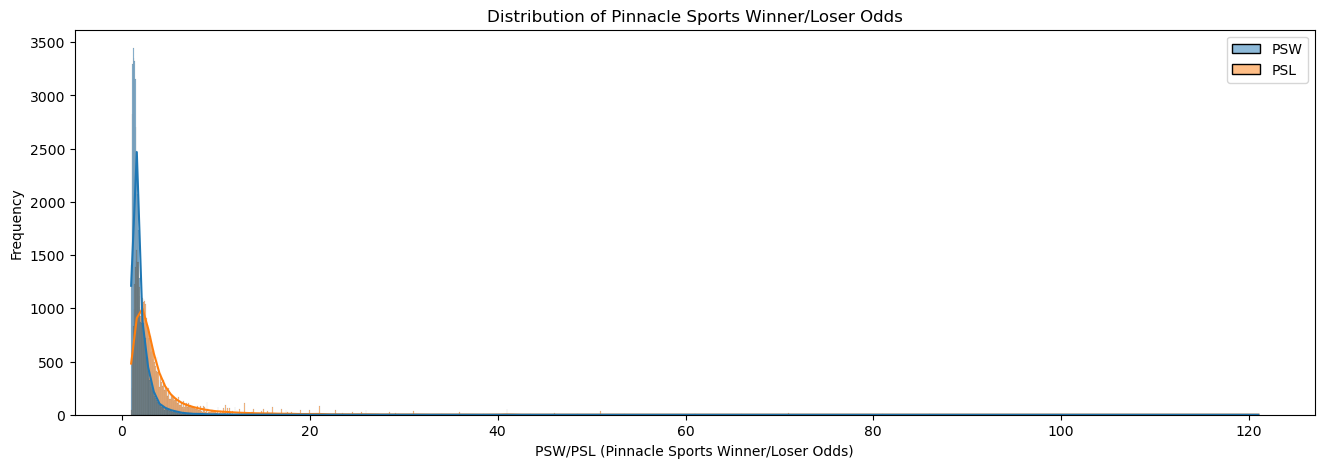

They max on 46.0 (for winners) and 121.0 (for losers).


In [14]:
# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp[["PSW", "PSL"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp['PSW'].max()} (for winners) and {df_atp['PSL'].max()} (for losers).")

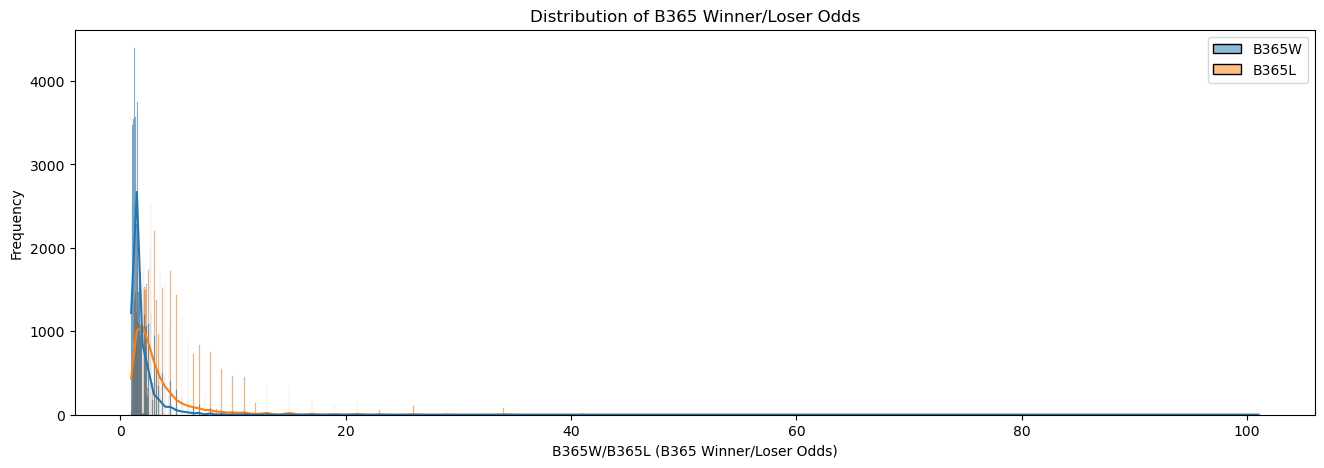

They max on 34.0 (for winners) and 101.0 (for losers).


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp['B365W'].max()} (for winners) and {df_atp['B365L'].max()} (for losers).")

In [ ]:
# Player statistics:
def take_statistics(df: pd.DataFrame):
    # Take out win and loss statistics
    win_count = df["Winner"].value_counts()
    win_count = pd.DataFrame({"Player": win_count.index , "Wins_count": win_count.values})

    loss_count = df["Loser"].value_counts()
    loss_count = pd.DataFrame({"Player": loss_count.index , "Losses_count": loss_count.values})

    # Merge the two dataframes
    players_statistics = loss_count.merge(right=win_count, how="outer", on="Player")
    players_statistics.fillna(value=0 ,inplace=True)

    # Calculate the win ratios
    players_statistics["Games_count"] = players_statistics["Losses_count"] + players_statistics["Wins_count"]
    players_statistics["Win_ratio"] = players_statistics["Wins_count"] / players_statistics["Games_count"]

    # Clean up the columns
    players_statistics[["Games_count", "Wins_count", "Losses_count"]] = players_statistics[["Games_count", "Wins_count", "Losses_count"]].astype("int")
    players_statistics = players_statistics.sort_values(by=["Games_count", "Win_ratio"], ascending=False).reset_index().drop(labels="index", axis=1)

    return players_statistics


# Show first rows
players_statistics = take_statistics(df_atp)
players_statistics.head(10)

print(players_statistics.sort_values(by="Player")["Player"].unique().tolist())

In [ ]:
top_n = 10

plt.figure(figsize=(16, 5))
sns.barplot(x=players_statistics["Player"].iloc[:top_n], y=players_statistics["Win_ratio"].iloc[:top_n])

plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("Wins")
plt.title("Player Wins Bar Plot")

plt.show()

In [ ]:
court_types = df_atp["Surface"].unique()

court_specific_player_statistics = {}
for court in court_types:
    court_specific_player_statistics[court] = take_statistics(df_atp[df_atp["Surface"]==court])

court_specific_player_statistics["Clay"].sort_values(by="Win_ratio", ascending=False).head(20)

In [ ]:
court_specific_player_statistics["Carpet"].sort_values(by="Win_ratio", ascending=False).head(20)

In [ ]:
court_specific_player_statistics["Hard"].sort_values(by="Win_ratio", ascending=False).head(20)

In [ ]:
court_specific_player_statistics["Grass"].sort_values(by="Win_ratio", ascending=False).head(20)

# It's time to define some betting strategies:
1. To bet on the higher ranked player (HRBS)
2. To bet on the lower ranked player (LRBS)
3. To bet on a random player (RPBS)
4. To bet on the player with the bettr win ratio (BWRBS)
5. To bet on the player with the better win ratio in the appropirate court type (BWRCTBS)
6. To bet on the winner always (WPBS)
7. To bet on the loser always (LPBS)

Ofcourse, the strategies 5 and 6 are just theoretical and put there to compare the strategies with the theoretical maximum profit.

In [ ]:
profit = df_atp[["Surface", "Winner", "Loser", "PSW", "B365W", "elo_winner", "elo_loser", "proba_elo"]].copy()

# Strategy 1
strategies = pd.DataFrame(df_atp["elo_winner"] > df_atp["elo_loser"], columns=["HRBS"], index=df_atp.index)
profit[["HRBS_PS", "HRBS_B365"]] = profit[strategies["HRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "HRBS_PS", "B365W": "HRBS_B365"}) - 1

# Strategy 2
strategies["LRBS"] = df_atp["elo_winner"] < df_atp["elo_loser"]
profit[["LRBS_PS", "LRBS_B365"]] = profit[strategies["LRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "LRBS_PS", "B365W": "LRBS_B365"}) - 1

# Strategy 3
np.random.seed(13572)
strategies["RPBS"] = np.random.randint(0, 2, size=len(strategies))==1
profit[["RPBS_PS", "RPBS_B365"]] = profit[strategies["RPBS"]][["PSW", "B365W"]].rename(columns={"PSW": "RPBS_PS", "B365W": "RPBS_B365"}) - 1

# Strategy 4
strategies["BWRBS"] = profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Winner", right_on="Player", how="left").set_index(profit.index)["Win_ratio"] > profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Loser", right_on="Player", how="left").set_index(profit.index)["Win_ratio"]
profit[["BWRBS_PS", "BWRBS_B365"]] = profit[strategies["BWRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "BWRBS_PS", "B365W": "BWRBS_B365"}) - 1

# # Strategy 5
# court_specific_player_statistics[profit["Surface"]]
# profit[["BWRBS_PS", "BWRBS_B365"]] = profit[profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Winner", right_on="Player", how="left").set_index(profit.index)["Win_ratio"] > profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Loser", right_on="Player", how="left").set_index(profit.index)["Win_ratio"]][["PSW", "B365W"]].rename(columns={"PSW": "BWRBS_PS", "B365W": "BWRBS_B365"}) - 1
# # To Be Continued

profit.dropna(axis=0, subset=["PSW", "B365W"], inplace=True)
profit.fillna(value=-1.0, inplace=True)

profit.head(20)

In [16]:
# Each cell in the dataframe features answers to the question whether the specified strategy predicts that player one wins
# Before constructing the dataframe we should scramble the players so that sometimes player 1 wins and he loses the other times with equal probabilities.
np.random.seed(98245)
features = pd.DataFrame(np.random.randint(0, 2, size=len(strategies))==1, columns=["P1==Winner"], index=strategies.index)

for feat in strategies.keys():
    features[feat+"_p1"] = ~np.bitwise_xor(features["P1==Winner"], strategies[feat])
    
features.head()

NameError: name 'strategies' is not defined

In [17]:
import sklearn.ensemble
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features.drop(labels=["P1==Winner", "LRBS_p1"], axis=1), features["P1==Winner"], test_size=0.2, random_state=42)

clf = sklearn.ensemble.RandomForestClassifier(max_depth=15, random_state=26895645)
clf.fit(X_train, y_train)

print(f"Random forest with the given features can predict correctly with the probability of {round(clf.score(X_test, y_test)*100, 2)} %")
profits_test = pd.DataFrame({"profit_PS": pd.DataFrame({"result": ~np.logical_xor(clf.predict(X_test), y_test)}, index=y_test.index).replace({True: 1.0, False: 0.0})["result"].to_numpy() * df_atp["PSW"].iloc[y_test.index].to_numpy() - 1.0, "profit_B365": pd.DataFrame({"result": ~np.logical_xor(clf.predict(X_test), y_test)}, index=y_test.index).replace({True: 1.0, False: 0.0})["result"].to_numpy() * df_atp["B365W"].iloc[y_test.index].to_numpy() - 1.0}, index=y_test.index).dropna(axis=0)
profit[["Random_forest_PS", "Random_forest_B365"]] = profits_test
profits_test.describe()
# profit[["Random_forest_PS", "Random_forest_B365"]].describe()
# y_train.iloc[40384]

NameError: name 'features' is not defined

In [18]:
df_atp.isnull().sum()

Unnamed: 0        0
ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of          15
Winner            0
Loser             0
WRank            23
LRank           139
Wsets           308
Lsets           310
Comment           0
B365W          8709
B365L          8686
PSW           15012
PSL           15012
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

In [19]:
df_atp_reduced.isnull().sum()

Unnamed: 0      0
ATP             0
Location        0
Tournament      0
Date            0
Series          0
Court           0
Surface         0
Round           0
Best of        15
Winner          0
Loser           0
WRank          18
LRank          93
Wsets         267
Lsets         269
Comment         0
B365W           0
B365L           0
PSW             0
PSL             0
elo_winner      0
elo_loser       0
proba_elo       0
dtype: int64

In [20]:
cleaned_df = df_atp_reduced.dropna()

In [ ]:
cleaned_df.isnull().sum()
cleaned_df.head()
cleaned_df["Date"].sort_values(ascending = False)
counts = cleaned_df.value_counts()


C:\Users\Patrick\AppData\Local\Temp\ipykernel_3984\987408721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Year'] = cleaned_df['Date'].dt.year


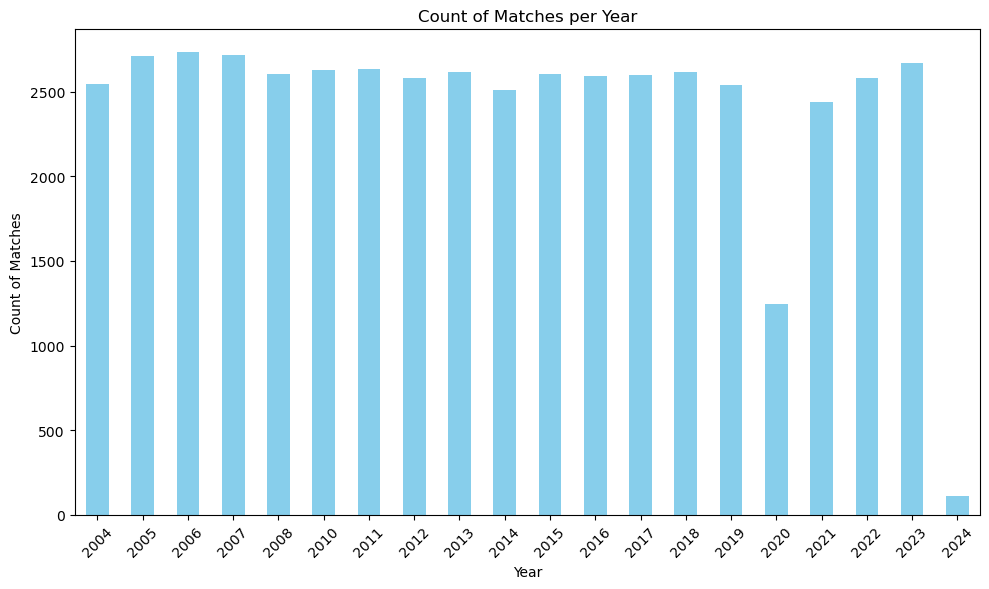

In [21]:
# Extract year from the 'Date' column
cleaned_df['Year'] = cleaned_df['Date'].dt.year

# Count matches per year
matches_per_year = cleaned_df['Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
matches_per_year.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Count of Matches')
plt.title('Count of Matches per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Save DataFrame to a CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)


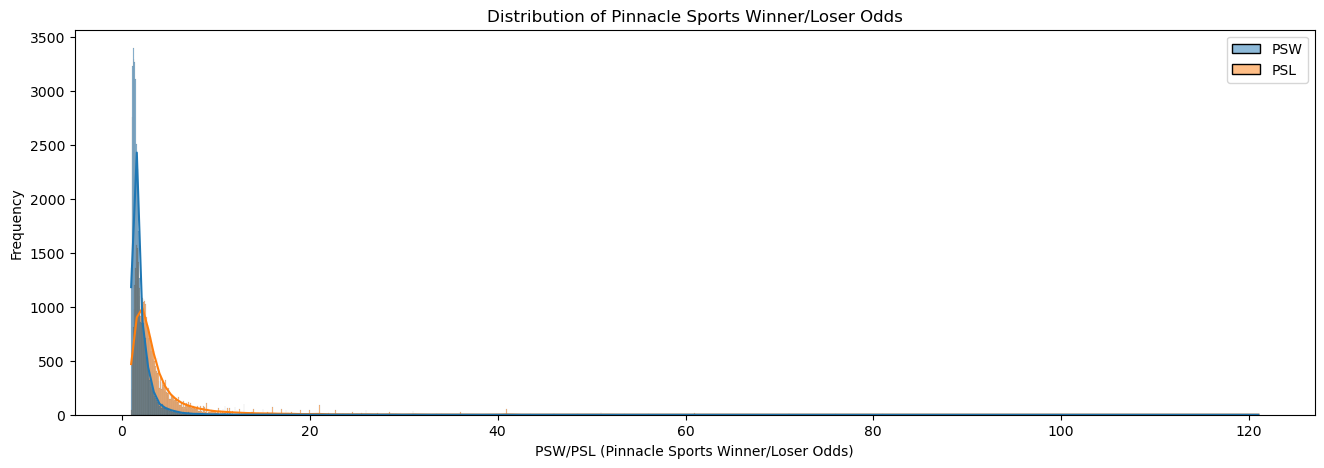

They max on 46.0 (for winners) and 121.0 (for losers).


In [22]:
# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(cleaned_df[["PSW", "PSL"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {cleaned_df['PSW'].max()} (for winners) and {cleaned_df['PSL'].max()} (for losers).")

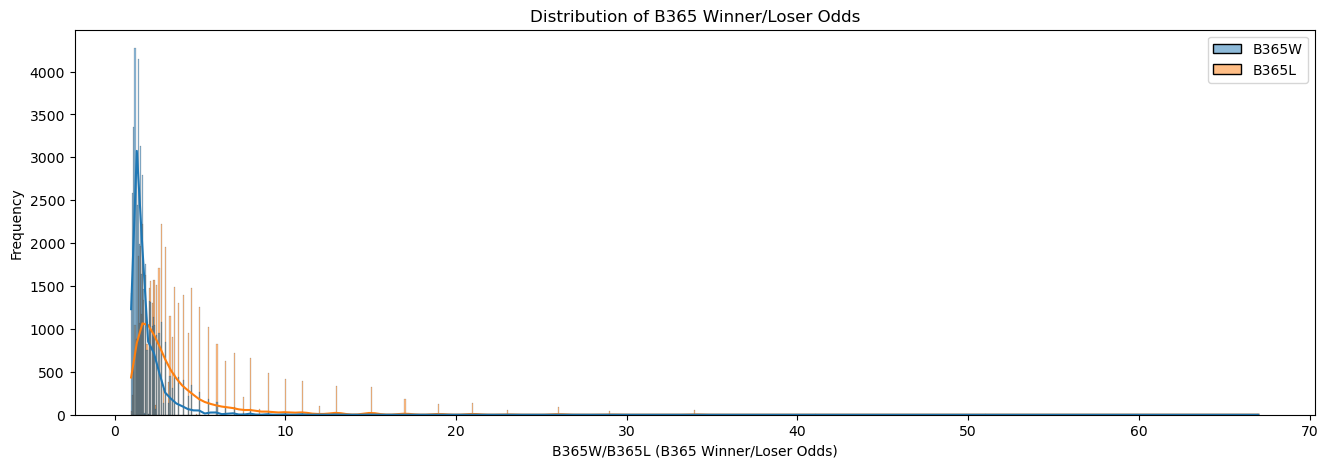

They max on 34.0 (for winners) and 67.0 (for losers).


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(cleaned_df[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {cleaned_df['B365W'].max()} (for winners) and {cleaned_df['B365L'].max()} (for losers).")